# 🧩 Task 8 — End-to-End ML Pipeline with Scikit-learn

In this task, we build a complete **end-to-end machine learning pipeline** using the built-in **Breast Cancer dataset** from Scikit-learn.  
The pipeline includes:
- Data loading and preprocessing  
- Exploratory Data Analysis (EDA)
- Train-test splitting and pipeline creation  
- Model training and evaluation (Logistic Regression, Random Forest, etc.)  
- Hyperparameter tuning with GridSearchCV  
- Saving and reloading the best pipeline  
- Deployment demo with **Gradio**

This demonstrates the **automation of preprocessing + modeling in one unified pipeline** — a key professional ML skill.  


In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
import joblib, json, time, os, warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Load Dataset
Use scikit-learn `load_breast_cancer` and create DataFrame for convenience.


In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")
X.shape, y.shape, y.value_counts(normalize=True).round(3)


((569, 30),
 (569,),
 target
 1    0.627
 0    0.373
 Name: proportion, dtype: float64)

## Quick Peek
Head, describe, and target distribution.


In [6]:
display(X.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
display(X.describe().T.round(3))

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127,3.524,6.981,11.700,13.370,15.780,28.110
mean texture,569.0,19.290,4.301,9.710,16.170,18.840,21.800,39.280
mean perimeter,569.0,91.969,24.299,43.790,75.170,86.240,104.100,188.500
mean area,569.0,654.889,351.914,143.500,420.300,551.100,782.700,2501.000
mean smoothness,569.0,0.096,0.014,0.053,0.086,0.096,0.105,0.163
mean compactness,569.0,0.104,0.053,0.019,0.065,0.093,0.130,0.345
mean concavity,569.0,0.089,0.080,0.000,0.030,0.062,0.131,0.427
mean concave points,569.0,0.049,0.039,0.000,0.020,0.034,0.074,0.201
mean symmetry,569.0,0.181,0.027,0.106,0.162,0.179,0.196,0.304
mean fractal dimension,569.0,0.063,0.007,0.050,0.058,0.062,0.066,0.097


In [8]:
y.value_counts().rename(index={0:'malignant',1:'benign'})

,count
target,
benign,357
malignant,212


##  Target Class Distribution
Check how balanced the dataset is (Benign vs Malignant).


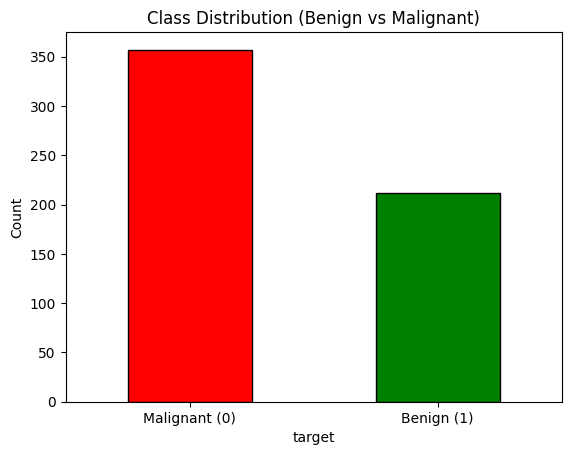

In [37]:
y.value_counts().plot(kind="bar", color=["red","green"], edgecolor="black")
plt.title("Class Distribution (Benign vs Malignant)")
plt.xticks(ticks=[0,1], labels=["Malignant (0)","Benign (1)"], rotation=0)
plt.ylabel("Count")
plt.show()


##  Feature Correlation Heatmap
Examine pairwise correlations among features.


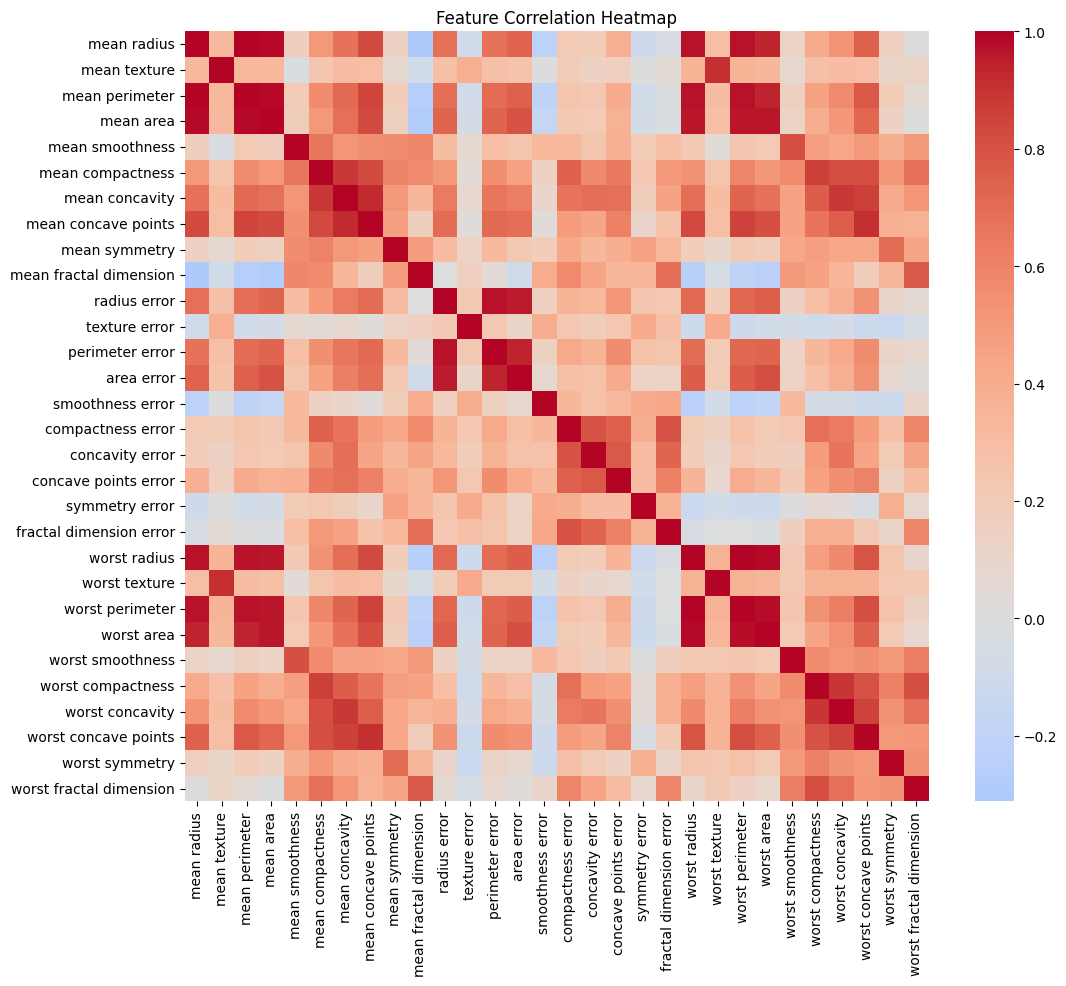

In [38]:
import seaborn as sns
corr = X.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()


## Mean Radius vs Mean Texture
Scatter plot to see separation between classes.


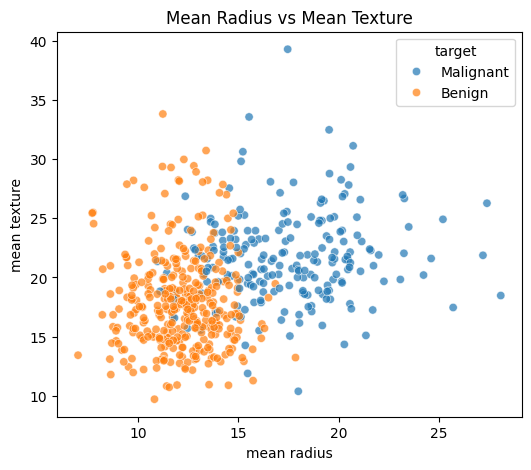

In [39]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X["mean radius"], y=X["mean texture"], hue=y.map({0:"Malignant",1:"Benign"}), alpha=0.7)
plt.title("Mean Radius vs Mean Texture")
plt.show()


## Distribution of Mean Radius
Histogram split by class.


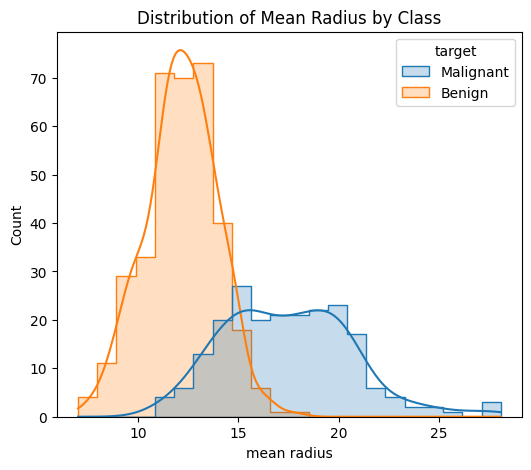

In [40]:
plt.figure(figsize=(6,5))
sns.histplot(x=X["mean radius"], hue=y.map({0:"Malignant",1:"Benign"}), kde=True, element="step")
plt.title("Distribution of Mean Radius by Class")
plt.show()

## Distribution of Mean Texture
Another important feature for separating classes.


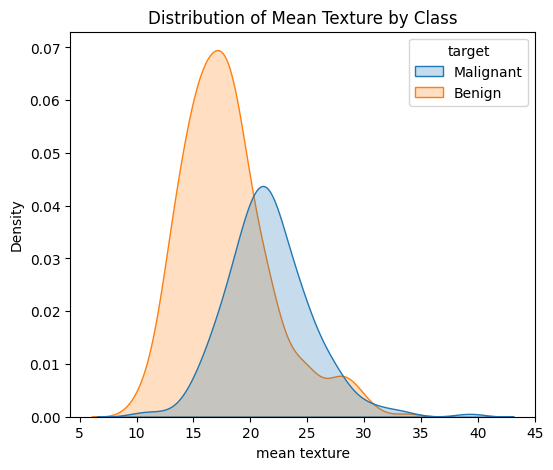

In [41]:
plt.figure(figsize=(6,5))
sns.kdeplot(x=X["mean texture"], hue=y.map({0:"Malignant",1:"Benign"}), fill=True)
plt.title("Distribution of Mean Texture by Class")
plt.show()


## Boxplot of Worst Radius
Boxplot to see variation across classes.


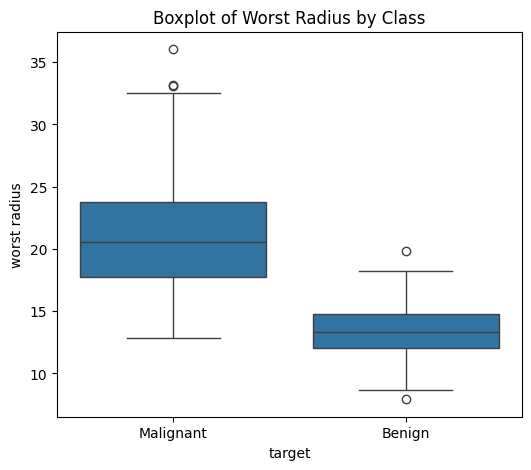

In [42]:
plt.figure(figsize=(6,5))
sns.boxplot(x=y.map({0:"Malignant",1:"Benign"}), y=X["worst radius"])
plt.title("Boxplot of Worst Radius by Class")
plt.show()


## Pairplot of Top Features
Visualize pairwise relationships between top 4 features, colored by class.


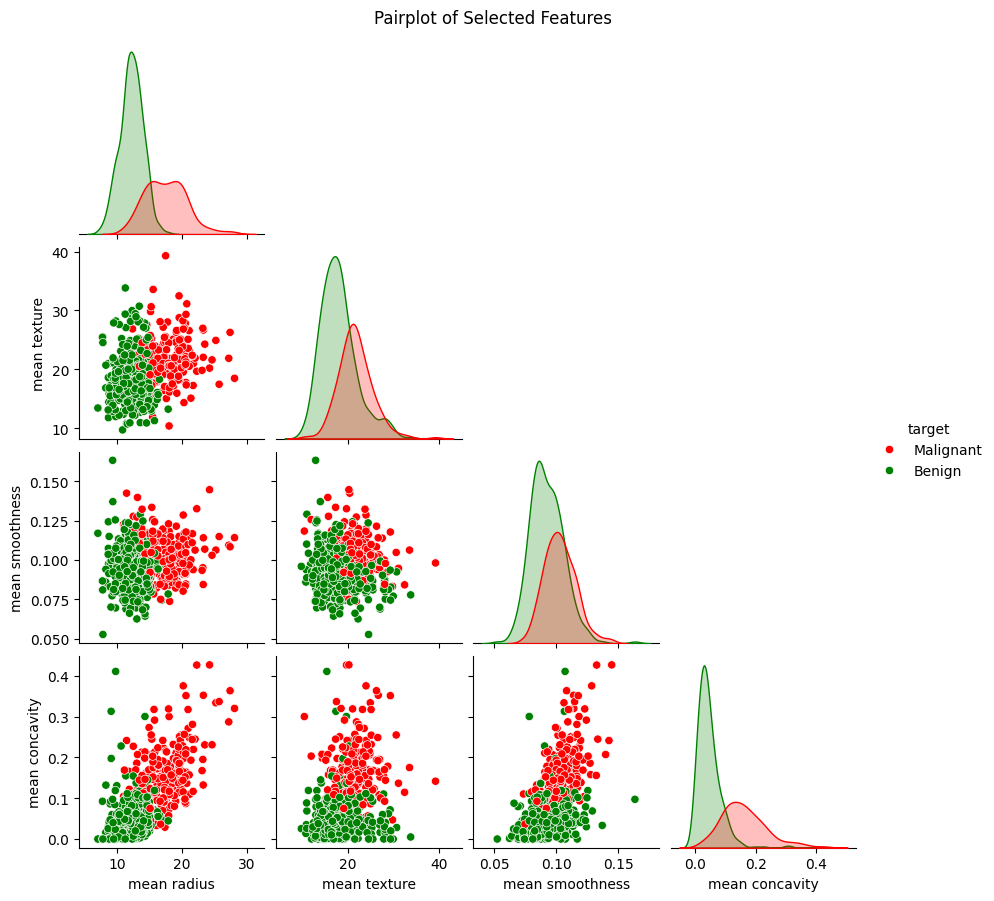

In [45]:
top_feats = ["mean radius", "mean texture", "mean smoothness", "mean concavity"]

sns.pairplot(
    pd.concat([X[top_feats], y.map({0:"Malignant",1:"Benign"})], axis=1),
    vars=top_feats,
    hue="target",
    palette={"Malignant":"red", "Benign":"green"},
    diag_kind="kde",
    corner=True,
    height=2.2,   # controls subplot height
    aspect=1      # keeps them square
)
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()


## PCA 2D Projection
Project features into 2D space with PCA to visualize clusters.


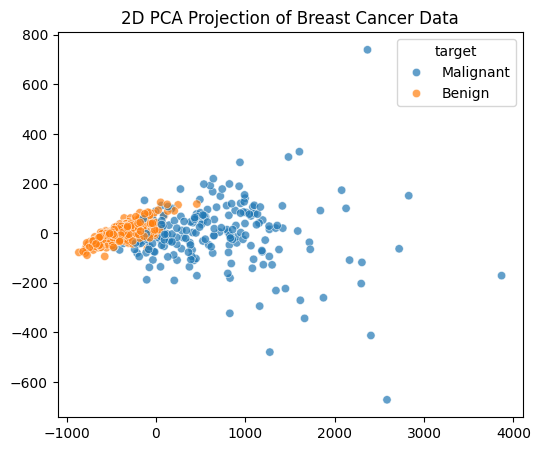

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y.map({0:"Malignant",1:"Benign"}), alpha=0.7)
plt.title("2D PCA Projection of Breast Cancer Data")
plt.show()


## Train/Validation/Test Split
Hold out test set; keep validation via CV.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape


((455, 30), (114, 30))

## Preprocessing
All numeric features: impute (median) + scale (StandardScaler).


In [10]:
numeric_features = X.columns.tolist()
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocess = ColumnTransformer(
    transformers=[("num", numeric_preprocess, numeric_features)],
    remainder="drop",
    n_jobs=None
)
preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['mean radius', 'mean texture',
                                  'mean perimeter', 'mean area',
                                  'mean smoothness', 'mean compactness',
                                  'mean concavity', 'mean concave points',
                                  'mean symmetry', 'mean fractal dimension',
                                  'radius error', 'texture error',
                                  'perimeter error', 'area error',
                                  'smoothness error', 'compactness error',
                                  'concavity error', 'concave points error',
                                  'symmetry error', 'fractal dimension error',
                                  'worst radius', 'worst texture',
                                  'worst perimeter', 'worst area',
                                  'worst smoothness', 'worst compactness',
                                  'worst concavity', 'worst concave points',
                                  'worst symmetry',
                                  'worst fractal dimension'])])

## Baseline Model — Logistic Regression
Pipeline: preprocess → LogisticRegression (liblinear, balanced).


In [11]:
pipe_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE))
])
pipe_lr


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['mean radius',
                                                   'mean texture',
                                                   'mean perimeter',
                                                   'mean area',
                                                   'mean smoothness',
                                                   'mean compactness',
                                                   'mean concavity',
                                                   'mean concave points',
                                                   'mean symmetry',
                                                   'mean fractal dimension',
                                                   'radius error',
                                                   'texture error',
                                                   'pe...
                                                   'compactness error',
                                                   'concavity error',
                                                   'concave points error',
                                                   'symmetry error',
                                                   'fractal dimension error',
                                                   'worst radius',
                                                   'worst texture',
                                                   'worst perimeter',
                                                   'worst area',
                                                   'worst smoothness',
                                                   'worst compactness',
                                                   'worst concavity',
                                                   'worst concave points',
                                                   'worst symmetry',
                                                   'worst fractal '
                                                   'dimension'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=42))])

## Baseline Training & Evaluation (Hold-out)
Report Accuracy, Macro-F1, ROC-AUC on test set.


In [12]:
pipe_lr.fit(X_train, y_train)
pred = pipe_lr.predict(X_test)
proba = pipe_lr.predict_proba(X_test)[:,1]
baseline_metrics = {
    "accuracy": accuracy_score(y_test, pred),
    "f1_macro": f1_score(y_test, pred, average="macro"),
    "roc_auc": roc_auc_score(y_test, proba)
}
baseline_metrics


{'accuracy': 0.956140350877193,
 'f1_macro': 0.9535338713621913,
 'roc_auc': np.float64(0.9953703703703703)}

## Cross-Validation (Stratified 5-fold)
More robust performance estimate.


In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_acc = cross_val_score(pipe_lr, X, y, cv=cv, scoring="accuracy")
cv_f1  = cross_val_score(pipe_lr, X, y, cv=cv, scoring="f1_macro")
cv_auc = cross_val_score(pipe_lr, X, y, cv=cv, scoring="roc_auc")
{"acc_mean": cv_acc.mean(), "f1_mean": cv_f1.mean(), "auc_mean": cv_auc.mean()}

{'acc_mean': np.float64(0.971914299021891),
 'f1_mean': np.float64(0.969869103465923),
 'auc_mean': np.float64(0.9950516622560514)}

## Confusion Matrix (Baseline)
Visualize errors on test set.


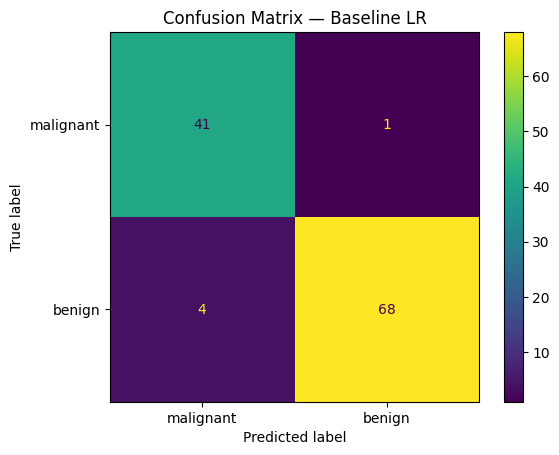

array([[41,  1],
       [ 4, 68]])

In [14]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=data.target_names)
disp.plot(values_format="d"); plt.title("Confusion Matrix — Baseline LR"); plt.show()
cm

## ROC Curve (Baseline)
Threshold-free performance visualization.


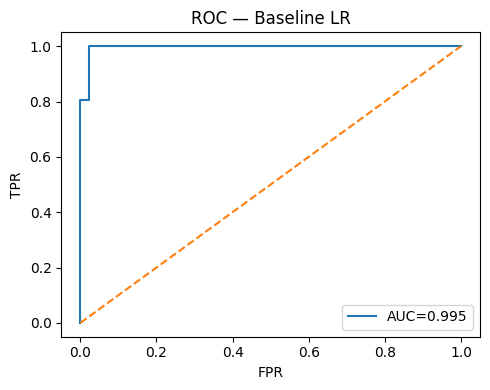

In [15]:
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, proba):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Baseline LR"); plt.legend(); plt.tight_layout(); plt.show()


## Precision-Recall Curve (Baseline)
Useful for class-imbalance.


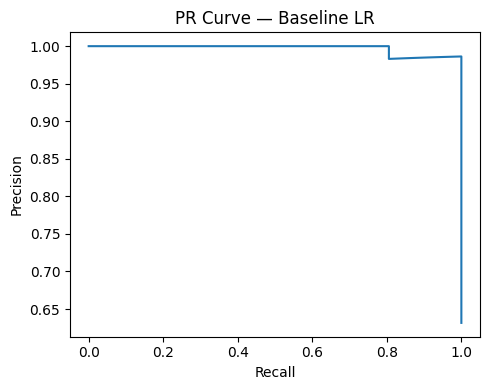

In [16]:
prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve — Baseline LR"); plt.tight_layout(); plt.show()


## Classification Report (Baseline)
Per-class precision/recall/F1.


In [17]:
print(classification_report(y_test, pred, target_names=data.target_names))

              precision    recall  f1-score   support

   malignant       0.91      0.98      0.94        42
      benign       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



## Alternative Models
Try RandomForest and GradientBoosting inside pipelines.


In [18]:
pipe_rf = Pipeline([("prep", preprocess),
                    ("clf", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE))])

pipe_gb = Pipeline([("prep", preprocess),
                    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))])

models = {"LogReg": pipe_lr, "RF": pipe_rf, "GB": pipe_gb}
models

{'LogReg': Pipeline(steps=[('prep',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['mean radius',
                                                    'mean texture',
                                                    'mean perimeter',
                                                    'mean area',
                                                    'mean smoothness',
                                                    'mean compactness',
                                                    'mean concavity',
                                                    'mean concave points',

## Quick CV Comparison (Accuracy/F1/AUC)
Select promising model for tuning.


In [19]:
def cv_scores(model):
    return {
        "acc": cross_val_score(model, X, y, cv=cv, scoring="accuracy").mean(),
        "f1" : cross_val_score(model, X, y, cv=cv, scoring="f1_macro").mean(),
        "auc": cross_val_score(model, X, y, cv=cv, scoring="roc_auc").mean(),
    }

cv_table = {name: cv_scores(m) for name,m in models.items()}
pd.DataFrame(cv_table).T.sort_values("auc", ascending=False)


,acc,f1,auc
LogReg,0.971914,0.969869,0.995052
GB,0.949076,0.944624,0.992731
RF,0.952569,0.948947,0.989477


## Hyperparameter Tuning — Logistic Regression
GridSearchCV around C and penalty.


In [20]:
param_lr = {
    "clf__C": [0.1, 0.5, 1.0, 2.0, 5.0],
    "clf__penalty": ["l2"],
    "clf__solver": ["liblinear", "lbfgs"]
}
grid_lr = GridSearchCV(pipe_lr, param_grid=param_lr, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True)
grid_lr.fit(X_train, y_train)
grid_lr.best_params_, grid_lr.best_score_


({'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'},
 np.float64(0.9957688338493291))

## Hyperparameter Tuning — RandomForest
Grid on trees, depth, and features.


In [21]:
param_rf = {
    "clf__n_estimators": [200, 400, 600],
    "clf__max_depth": [None, 6, 10],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2]
}
grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True)
grid_rf.fit(X_train, y_train)
grid_rf.best_params_, grid_rf.best_score_


({'clf__max_depth': 6,
  'clf__min_samples_leaf': 1,
  'clf__min_samples_split': 2,
  'clf__n_estimators': 600},
 np.float64(0.9906088751289989))

## Hyperparameter Tuning — GradientBoosting
Small grid for speed.


In [22]:
param_gb = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__max_depth": [2, 3]
}
grid_gb = GridSearchCV(pipe_gb, param_grid=param_gb, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True)
grid_gb.fit(X_train, y_train)
grid_gb.best_params_, grid_gb.best_score_


({'clf__learning_rate': 0.1, 'clf__max_depth': 2, 'clf__n_estimators': 200},
 np.float64(0.9928792569659443))

## Select Best-Tuned Model
Compare CV AUC of tuned candidates.


In [23]:
tuned = {
    "LR_tuned": (grid_lr.best_estimator_, grid_lr.best_score_),
    "RF_tuned": (grid_rf.best_estimator_, grid_rf.best_score_),
    "GB_tuned": (grid_gb.best_estimator_, grid_gb.best_score_)
}
best_name, (best_model, best_cv_auc) = sorted(tuned.items(), key=lambda kv: kv[1][1], reverse=True)[0]
best_name, best_cv_auc


('LR_tuned', np.float64(0.9957688338493291))

## Final Evaluation on Test Set (Best Model)
Accuracy, F1, AUC and report.


In [24]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]
final_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_macro": f1_score(y_test, y_pred, average="macro"),
    "roc_auc": roc_auc_score(y_test, y_proba),
    "model": best_name
}
print(final_metrics)
print(classification_report(y_test, y_pred, target_names=data.target_names))


{'accuracy': 0.956140350877193, 'f1_macro': 0.9535338713621913, 'roc_auc': np.float64(0.9957010582010581), 'model': 'LR_tuned'}
              precision    recall  f1-score   support

   malignant       0.91      0.98      0.94        42
      benign       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



## ROC & PR Curves (Best Model)
Visual diagnostics.


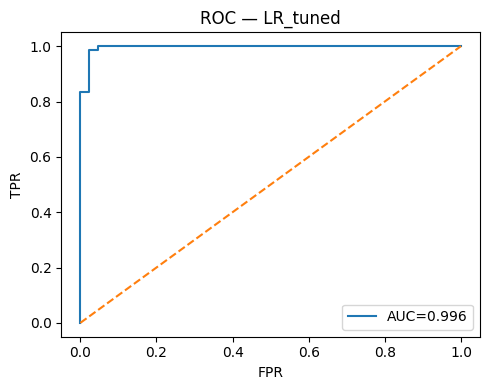

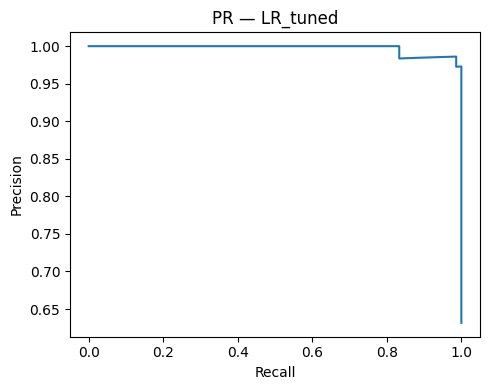

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {best_name}"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR — {best_name}"); plt.tight_layout(); plt.show()


## Confusion Matrix (Best Model)
Check misclassifications.


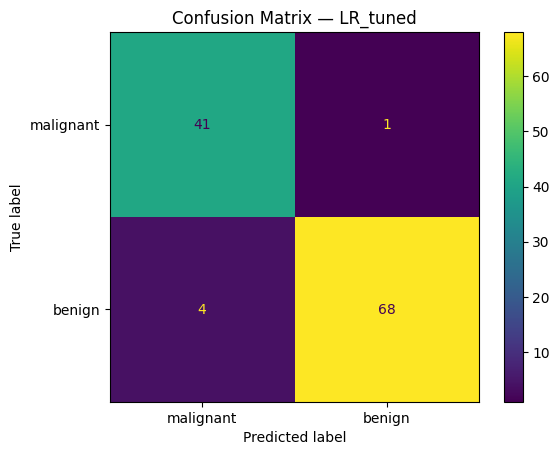

array([[41,  1],
       [ 4, 68]])

In [26]:
cm_best = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_best, display_labels=data.target_names).plot(values_format="d")
plt.title(f"Confusion Matrix — {best_name}"); plt.show()
cm_best


## Feature Importance (Permutation)
Model-agnostic importances on test set.


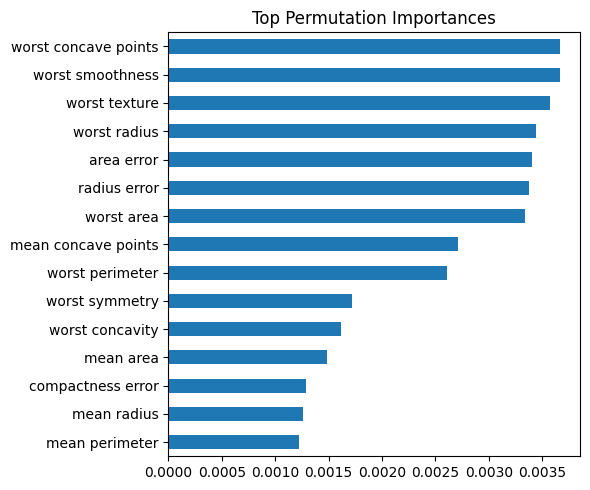

,0
worst concave points,0.003671
worst smoothness,0.003671
worst texture,0.003571
worst radius,0.003439
area error,0.003406
radius error,0.003373
worst area,0.003340
mean concave points,0.002712
worst perimeter,0.002612
worst symmetry,0.001720


In [27]:
# Use a pipeline-friendly permutation importance (on original X_test)
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, scoring="roc_auc")
pi = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(6,5)); pi[::-1].plot(kind="barh"); plt.title("Top Permutation Importances"); plt.tight_layout(); plt.show()
pi.head(10)


## Alternative Scaling (Ablation)
Try MinMax + LR to check sensitivity.


In [28]:
preprocess_minmax = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                                                         ("mm", MinMaxScaler())]), numeric_features)])
pipe_lr_mm = Pipeline([("prep", preprocess_minmax),
                       ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE))])
scores_mm = cross_val_score(pipe_lr_mm, X, y, cv=cv, scoring="roc_auc").mean()
{"LR_std_auc": cv_auc.mean(), "LR_minmax_auc": scores_mm}


{'LR_std_auc': np.float64(0.9950516622560514),
 'LR_minmax_auc': np.float64(0.9945247713672215)}

## Robust Pipeline Variant (QuantileTransformer)
Sanity check against heavy-tailed features.


In [29]:
preprocess_qt = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                                                     ("qt", QuantileTransformer(output_distribution="normal", random_state=RANDOM_STATE))]), numeric_features)])
pipe_lr_qt = Pipeline([("prep", preprocess_qt),
                       ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE))])
scores_qt = cross_val_score(pipe_lr_qt, X, y, cv=cv, scoring="roc_auc").mean()
{"LR_std_auc": cv_auc.mean(), "LR_qt_auc": scores_qt}


{'LR_std_auc': np.float64(0.9950516622560514),
 'LR_qt_auc': np.float64(0.9956418745028308)}

## Model Comparison Chart
Bar chart for baseline vs tuned models on CV AUC.


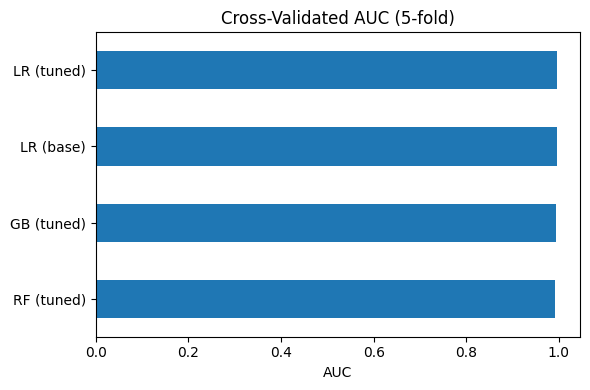

,0
RF (tuned),0.990609
GB (tuned),0.992879
LR (base),0.995052
LR (tuned),0.995769


In [30]:
comp = {
    "LR (base)": cv_auc.mean(),
    "LR (tuned)": tuned["LR_tuned"][1],
    "RF (tuned)": tuned["RF_tuned"][1],
    "GB (tuned)": tuned["GB_tuned"][1],
}
ser = pd.Series(comp).sort_values()
plt.figure(figsize=(6,4))
ser.plot(kind="barh")
plt.title("Cross-Validated AUC (5-fold)")
plt.xlabel("AUC")
plt.tight_layout(); plt.show()
ser


## Save Best Pipeline (joblib)
Persist full pipeline (preprocess + model).


In [31]:
os.makedirs("artifacts", exist_ok=True)
artifact_path = f"artifacts/breast_cancer_{best_name}_pipeline.joblib"
joblib.dump(best_model, artifact_path)
artifact_path


'artifacts/breast_cancer_LR_tuned_pipeline.joblib'

## Reload & Smoke Test
Ensure parity after loading.


In [32]:
loaded = joblib.load(artifact_path)
check_pred = loaded.predict(X_test)
np.mean(check_pred == y_pred), loaded.__class__.__name__


(np.float64(1.0), 'Pipeline')

## Export Metrics JSON
Store metrics + metadata for submission.


In [33]:
report = {
    "model": best_name,
    "cv_auc_best": float(best_cv_auc),
    "test": {k: float(v) for k,v in final_metrics.items() if k != "model"},
    "timestamp": int(time.time()),
    "features": numeric_features
}
os.makedirs("reports", exist_ok=True)
with open("reports/task8_metrics.json","w") as f: json.dump(report, f, indent=2)
report


{'model': 'LR_tuned',
 'cv_auc_best': 0.9957688338493291,
 'test': {'accuracy': 0.956140350877193,
  'f1_macro': 0.9535338713621913,
  'roc_auc': 0.9957010582010581},
 'timestamp': 1755973521,
 'features': ['mean radius',
  'mean texture',
  'mean perimeter',
  'mean area',
  'mean smoothness',
  'mean compactness',
  'mean concavity',
  'mean concave points',
  'mean symmetry',
  'mean fractal dimension',
  'radius error',
  'texture error',
  'perimeter error',
  'area error',
  'smoothness error',
  'compactness error',
  'concavity error',
  'concave points error',
  'symmetry error',
  'fractal dimension error',
  'worst radius',
  'worst texture',
  'worst perimeter',
  'worst area',
  'worst smoothness',
  'worst compactness',
  'worst concavity',
  'worst concave points',
  'worst symmetry',
  'worst fractal dimension']}

## Inference Helper
Predict on a few crafted samples (min/max/median modifications).


In [34]:
x_med = X_train.median()
x_hi  = X_train.iloc[0].copy(); x_hi[:] = X_train.quantile(0.9)
x_lo  = X_train.iloc[1].copy(); x_lo[:] = X_train.quantile(0.1)
samples = pd.DataFrame([x_lo, x_med, x_hi])
preds = loaded.predict(samples)
probs = loaded.predict_proba(samples)[:,1]
pd.DataFrame({"pred": preds, "prob_benign": probs.round(4)})


,pred,prob_benign
0,1,1.0000
1,1,0.9085
2,0,0.0000


## Gradio App (Local)
Simple UI to paste a JSON row → prediction.


In [36]:
import gradio as gr

feature_list = X.columns.tolist()
def predict_json(json_row: str):
    try:
        row = pd.DataFrame([json.loads(json_row)])
        row = row.reindex(columns=feature_list, fill_value=np.nan)
        p = loaded.predict_proba(row)[:,1][0]
        yhat = int(p >= 0.5)
        return f"Prediction: {['malignant','benign'][yhat]} | benign_prob={p:.4f}"
    except Exception as e:
        return f"Error: {e}"

demo = gr.Interface(fn=predict_json,
                    inputs=gr.Textbox(lines=8, placeholder="Paste JSON with all feature keys..."),
                    outputs=gr.Textbox(),
                    title=f"Task 8 — {best_name} Breast Cancer Classifier",
                    description="Input a JSON dict with scikit-learn breast_cancer features to get prediction.")
demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4843e8231164a2ce8c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
